In [1]:
"""
hnsw_full_implementation.py

Production-ready HNSW (Hierarchical Navigable Small World) implementation in Python.

Features:
- Multi-layer HNSW graph with probabilistic level assignment
- Thread-safe incremental add_point (real-time inserts) and search
- ef_construction / ef_search parameters, M (max neighbors) and mL level multiplier
- Diversity-aware neighbor selection heuristic (HNSW paper / visual guide)
- Persistence: save() / load() (numpy + JSON)
- Deletion (lazy tombstone) + rebuild to compact the graph
- Support for Euclidean (L2) and Cosine distance metrics
- CLI for build/query/serve and simple FastAPI endpoint (optional)

Reference: "A Visual Guide to HNSW" (Christopher Fu, May 2024)
"""

from __future__ import annotations

import math
import random
import threading
import heapq
import json
import os
import argparse
from typing import List, Tuple, Dict, Optional, Callable

import numpy as np

try:
    from fastapi import FastAPI, HTTPException
    import uvicorn
    _HAS_FASTAPI = True
except Exception:
    _HAS_FASTAPI = False


# ---------------------------
# Distance metrics
# ---------------------------

def l2_distance(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))


def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 1.0
    cos = float(np.dot(a, b) / (na * nb))
    return 1.0 - cos


_METRICS: Dict[str, Callable[[np.ndarray, np.ndarray], float]] = {
    "l2": l2_distance,
    "cosine": cosine_distance,
}


# ---------------------------
# HNSW Class
# ---------------------------

class HNSW:
    """Hierarchical Navigable Small World index.

    Attributes:
        dim: vector dimensionality
        M: max neighbors per node (levels > 0)
        ef_construction: ef used during insertion
        ef_search: default ef used during queries
        mL: level multiplier for random level generation
        metric_name: 'l2' or 'cosine'
    """

    def __init__(self,
                 dim: int,
                 M: int = 16,
                 ef_construction: int = 200,
                 ef_search: int = 50,
                 mL: Optional[float] = None,
                 metric: str = "l2",
                 max_m0: Optional[int] = None,
                 seed: Optional[int] = 42):
        if metric not in _METRICS:
            raise ValueError(f"Unsupported metric: {metric}")

        self.dim = int(dim)
        self.M = int(M)
        self.ef_construction = int(ef_construction)
        self.ef_search = int(ef_search)
        self.mL = float(mL) if mL is not None else 1.0 / math.log(max(2, M))
        self.metric_name = metric
        self._dist_fn = _METRICS[metric]

        # degree cap for layer 0 can be larger; default to 2*M if not provided
        self.max_m0 = int(max_m0) if max_m0 is not None else (self.M * 2)

        # core storage
        self.vectors: List[np.ndarray] = []
        self.levels: List[int] = []
        self.graph: List[Dict[int, List[int]]] = []
        self.tombstones: List[bool] = []

        # concurrency
        self._lock = threading.RLock()
        self.entry_point: Optional[int] = None
        self.max_layer: int = -1

        # RNG
        self._rand = random.Random(seed)

    # ----------------
    # Low-level helpers
    # ----------------
    def _random_level(self) -> int:
        # Random level generation: floor(-ln(U) * mL)
        u = self._rand.random()
        if u <= 0.0:
            u = 1e-16
        lvl = int(-math.log(u) * self.mL)
        return lvl

    def _dist(self, a_idx: int, vec: np.ndarray) -> float:
        return self._dist_fn(self.vectors[a_idx], vec)

    # ----------------
    # Neighbor selection heuristic
    # ----------------
    def _select_neighbors(self, candidates: List[Tuple[float, int]], M: int) -> List[int]:
        """Select up to M neighbors from candidates (sorted by dist asc) using HNSW heuristic.

        The heuristic prefers diverse neighbors: a candidate is skipped if an already selected
        neighbor is closer to the candidate than the candidate's distance to the query (redundancy check).
        """
        selected: List[int] = []
        for dist, nid in candidates:
            ok = True
            for sid in selected:
                d_between = self._dist_fn(self.vectors[sid], self.vectors[nid])
                if d_between < dist:
                    ok = False
                    break
            if ok:
                selected.append(nid)
                if len(selected) >= M:
                    break
        return selected

    # ----------------
    # ef-search on a layer
    # ----------------
    def _search_layer(self, query_vec: np.ndarray, entry_point: int, ef: int, layer: int) -> List[int]:
        """Return up to ef best candidates on a given layer starting from entry_point."""
        visited = set()
        # top_candidates: max-heap by negative distance (keeps best ef found so far)
        top_heap: List[Tuple[float, int]] = []
        # candidates: min-heap by distance for exploration
        cand_heap: List[Tuple[float, int]] = []

        entry_dist = self._dist(entry_point, query_vec)
        heapq.heappush(top_heap, (-entry_dist, entry_point))
        heapq.heappush(cand_heap, (entry_dist, entry_point))
        visited.add(entry_point)

        while cand_heap:
            cur_dist, cur = cand_heap[0]
            # worst distance among top candidates (smallest priority in max-heap)
            worst_top = -top_heap[0][0]
            if len(top_heap) >= ef and cur_dist > worst_top:
                break
            heapq.heappop(cand_heap)
            neighs = self.graph[cur].get(layer, [])
            for n in neighs:
                if self.tombstones[n]:
                    continue
                if n in visited:
                    continue
                visited.add(n)
                d = self._dist(n, query_vec)
                if len(top_heap) < ef or d < -top_heap[0][0]:
                    heapq.heappush(cand_heap, (d, n))
                    heapq.heappush(top_heap, (-d, n))
                    if len(top_heap) > ef:
                        heapq.heappop(top_heap)

        # extract sorted ascending by distance
        res = sorted([(-d, nid) for (d, nid) in top_heap], key=lambda x: x[0])
        return [nid for (_d, nid) in res]

    # ----------------
    # Public API
    # ----------------
    def add_point(self, vector: np.ndarray) -> int:
        """Insert a vector into the HNSW index and return its id. Thread-safe."""
        if vector.shape[0] != self.dim:
            raise ValueError("Vector dimensionality mismatch")
        vec = vector.astype(np.float32)

        with self._lock:
            vid = len(self.vectors)
            self.vectors.append(vec)
            lvl = self._random_level()
            self.levels.append(lvl)
            self.tombstones.append(False)
            self.graph.append({})
            for l in range(lvl + 1):
                self.graph[vid].setdefault(l, [])

            # first element
            if self.entry_point is None:
                self.entry_point = vid
                self.max_layer = lvl
                return vid

            cur_ep = self.entry_point
            cur_max = self.max_layer

            # 1) greedy descent from top layer down to lvl+1 using ef=1 like greedy search
            for layer in range(cur_max, lvl, -1):
                improved = True
                while improved:
                    improved = False
                    neighs = self.graph[cur_ep].get(layer, [])
                    for n in neighs:
                        if self.tombstones[n]:
                            continue
                        if self._dist(n, vec) < self._dist(cur_ep, vec):
                            cur_ep = n
                            improved = True

            # 2) for layers <= lvl, run ef_construction (or ef=1) searches and connect
            for layer in range(min(lvl, cur_max), -1, -1):
                ef = self.ef_construction if layer <= lvl else 1
                ef = max(ef, 1)
                candidates = self._search_layer(vec, cur_ep, ef=ef, layer=layer)
                cand_dists = sorted([(self._dist(cid, vec), cid) for cid in candidates], key=lambda x: x[0])

                M_here = self.M if layer > 0 else self.max_m0
                selected = self._select_neighbors(cand_dists, M_here)

                # link bidirectionally and prune neighbor lists if needed
                for neigh in selected:
                    self.graph[vid].setdefault(layer, []).append(neigh)
                    neigh_adj = self.graph[neigh].setdefault(layer, [])
                    neigh_adj.append(vid)
                    if len(neigh_adj) > (self.M if layer > 0 else self.max_m0):
                        # prune to best by distance to neighbor
                        neigh_list = sorted([(self._dist(x, self.vectors[neigh]) if isinstance(self.vectors[neigh], np.ndarray) else self._dist(x, self.vectors[neigh]), x) for x in neigh_adj], key=lambda x: x[0])
                        keep = [x[1] for x in neigh_list[: (self.M if layer > 0 else self.max_m0)]]
                        self.graph[neigh][layer] = keep

                # set cur_ep to best candidate for next lower layer (closest)
                if len(cand_dists) > 0:
                    cur_ep = cand_dists[0][1]

            # update global entry point if this node has highest level
            if lvl > self.max_layer:
                self.max_layer = lvl
                self.entry_point = vid

            return vid

    def search(self, query_vec: np.ndarray, k: int = 10, ef: Optional[int] = None) -> List[Tuple[int, float]]:
        """Search k nearest neighbors. Returns list of (id, distance). Thread-safe."""
        if query_vec.shape[0] != self.dim:
            raise ValueError("Query dimensionality mismatch")
        with self._lock:
            if self.entry_point is None:
                return []
            ef = max(self.ef_search if ef is None else ef, k)

            cur = self.entry_point
            # greedy descent on higher layers
            for layer in range(self.max_layer, 0, -1):
                improved = True
                while improved:
                    improved = False
                    neighs = self.graph[cur].get(layer, [])
                    for n in neighs:
                        if self.tombstones[n]:
                            continue
                        if self._dist(n, query_vec) < self._dist(cur, query_vec):
                            cur = n
                            improved = True

            # base layer ef-search
            candidates = self._search_layer(query_vec, cur, ef=ef, layer=0)
            scored = [(nid, self._dist(nid, query_vec)) for nid in candidates]
            scored_sorted = sorted(scored, key=lambda x: x[1])[:k]
            return scored_sorted

    def delete(self, node_id: int) -> bool:
        """Lazy delete: mark node as tombstone. Returns True if deleted."""
        with self._lock:
            if node_id < 0 or node_id >= len(self.vectors):
                return False
            if self.tombstones[node_id]:
                return False
            self.tombstones[node_id] = True
            # Do not eagerly remove edges here — optional background cleanup can prune lists.
            return True

    # ----------------
    # Persistence
    # ----------------
    def save(self, path: str) -> None:
        """Save index to directory `path`. Creates directory if necessary."""
        os.makedirs(path, exist_ok=True)
        # stack vectors into 2D array
        if len(self.vectors) > 0:
            vecs = np.stack(self.vectors).astype(np.float32)
        else:
            vecs = np.zeros((0, self.dim), dtype=np.float32)
        np.save(os.path.join(path, "vectors.npy"), vecs)
        np.save(os.path.join(path, "levels.npy"), np.array(self.levels, dtype=np.int32))
        np.save(os.path.join(path, "tombstones.npy"), np.array(self.tombstones, dtype=np.bool_))

        # graph: serialize adjacency lists
        graph_serial = []
        for node_adj in self.graph:
            serial = {str(l): list(neighs) for l, neighs in node_adj.items()}
            graph_serial.append(serial)
        with open(os.path.join(path, "graph.json"), "w") as f:
            json.dump(graph_serial, f)

        meta = {
            "dim": self.dim,
            "M": self.M,
            "ef_construction": self.ef_construction,
            "ef_search": self.ef_search,
            "mL": self.mL,
            "metric": self.metric_name,
            "max_m0": self.max_m0,
            "entry_point": self.entry_point,
            "max_layer": self.max_layer,
        }
        with open(os.path.join(path, "meta.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load(cls, path: str) -> "HNSW":
        """Load an index from directory `path`."""
        with open(os.path.join(path, "meta.json"), "r") as f:
            meta = json.load(f)
        dim = int(meta["dim"])
        M = int(meta["M"])
        efc = int(meta.get("ef_construction", 200))
        efs = int(meta.get("ef_search", 50))
        mL = float(meta.get("mL", None)) if meta.get("mL", None) is not None else None
        metric = meta.get("metric", "l2")
        max_m0 = int(meta.get("max_m0", M * 2))

        idx = cls(dim=dim, M=M, ef_construction=efc, ef_search=efs, mL=mL, metric=metric, max_m0=max_m0)

        vecs = np.load(os.path.join(path, "vectors.npy"))
        levels = np.load(os.path.join(path, "levels.npy"))
        tomb = np.load(os.path.join(path, "tombstones.npy"))

        idx.vectors = [vecs[i].astype(np.float32) for i in range(vecs.shape[0])]
        idx.levels = [int(x) for x in levels.tolist()]
        idx.tombstones = [bool(x) for x in tomb.tolist()]

        with open(os.path.join(path, "graph.json"), "r") as f:
            graph_serial = json.load(f)
        idx.graph = []
        for node in graph_serial:
            d = {int(k): list(v) for k, v in node.items()}
            idx.graph.append(d)

        idx.entry_point = meta.get("entry_point", None)
        idx.max_layer = int(meta.get("max_layer", -1))
        return idx

    # ----------------
    # Rebuild after many deletions
    # ----------------
    def rebuild(self) -> "HNSW":
        """Return a new HNSW built from non-deleted vectors. Useful after many deletes."""
        with self._lock:
            alive_indices = [i for i, t in enumerate(self.tombstones) if not t]
            new_idx = HNSW(dim=self.dim, M=self.M, ef_construction=self.ef_construction,
                           ef_search=self.ef_search, mL=self.mL, metric=self.metric_name, max_m0=self.max_m0)
            for i in alive_indices:
                new_idx.add_point(self.vectors[i])
            return new_idx


# ---------------------------
# CLI and optional HTTP server
# ---------------------------

CLI_HELP = """
Simple CLI for building and querying the HNSW index.
Examples:
  python hnsw_full_implementation.py --build --n 1000 --dim 128 --out idx_dir
  python hnsw_full_implementation.py --load idx_dir --query-file queries.npy --k 5
  python hnsw_full_implementation.py --serve --load idx_dir --port 8000
"""


def _cli_build(args):
    idx = HNSW(dim=args.dim, M=args.M, ef_construction=args.efc, ef_search=args.efs, mL=args.mL, metric=args.metric)
    print(f"Building index with n={args.n}, dim={args.dim}")
    for i in range(args.n):
        vec = np.random.randn(args.dim).astype(np.float32)
        idx.add_point(vec)
        if (i + 1) % 1000 == 0:
            print(f"Inserted {i+1} / {args.n}")
    idx.save(args.out)
    print(f"Saved index to {args.out}")


def _cli_query(args):
    idx = HNSW.load(args.load)
    if args.query_file is None:
        q = np.random.randn(idx.dim).astype(np.float32)
        res = idx.search(q, k=args.k, ef=args.ef)
        print(res)
    else:
        qs = np.load(args.query_file)
        for i in range(min(len(qs), args.max_queries)):
            res = idx.search(qs[i].astype(np.float32), k=args.k, ef=args.ef)
            print(i, res)


def _cli_serve(args):
    if not _HAS_FASTAPI:
        raise RuntimeError("FastAPI/uvicorn not installed. Install to use --serve")
    idx = HNSW.load(args.load)
    app = FastAPI()

    @app.post('/search')
    def search_endpoint(body: dict):
        q = body.get('q')
        if q is None:
            raise HTTPException(status_code=400, detail='q field (array) required')
        qarr = np.array(q, dtype=np.float32)
        k = int(body.get('k', 10))
        ef = body.get('ef', None)
        res = idx.search(qarr, k=k, ef=ef)
        return {'result': res}

    uvicorn.run(app, host='0.0.0.0', port=args.port)




In [5]:
# Install necessary libraries if you haven't already:
!pip install torch torchvision pillow tqdm

In [6]:
import torch
from torchvision import models, transforms, datasets
from PIL import Image
from typing import Dict, Any
from tqdm import tqdm

# --- Global Model and Setup
_MODEL = None
_TRANSFORM = None
_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _initialize_model(model_name: str = 'resnet18') -> None:
    """Initializes the pre-trained model and transformation pipeline."""
    global _MODEL, _TRANSFORM

    print(f"Initializing model {model_name} on {_DEVICE}...")

    model_func = getattr(models, model_name)
    model = model_func(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # ResNet-18 output dimension is 512 before the final 'fc' layer
    model.fc = torch.nn.Identity()
    model.eval()
    model.to(_DEVICE)

    _TRANSFORM = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    _MODEL = model

def get_image_embedding_from_pil(img: Image.Image) -> np.ndarray:
    """
    Takes a PIL Image object and generates its embedding vector.
    """
    if _MODEL is None:
        _initialize_model()

    if _TRANSFORM is None:
        raise RuntimeError("Model transformation not initialized.")

    img = img.convert('RGB')

    # Apply transformations and add batch dimension
    img_tensor = _TRANSFORM(img).unsqueeze(0).to(_DEVICE)

    # Generate embedding
    with torch.no_grad():
        embedding = _MODEL(img_tensor).cpu().numpy().flatten()

    return embedding

# --- Configuration ---
IMAGE_DIM = 512 # ResNet-18 embedding size
INDEX_DIR = "cifar_hnsw_index"
N_IMAGES_TO_INDEX = 5000 # Use a subset for fast demonstration

In [7]:
def build_image_index(n_images: int, index_dir: str) -> HNSW:
    """
    Loads a real dataset, generates embeddings, and builds the HNSW index.
    """
    _initialize_model()

    # Load CIFAR-10 training set (32x32 images)
    print("Downloading/Loading CIFAR-10 dataset...")
    # We use the raw PIL image (not transformed yet)
    cifar_data = datasets.CIFAR10(root='./data', train=True, download=True)

    # 1. Generate all embeddings
    embeddings: Dict[int, np.ndarray] = {}
    print(f"Generating embeddings for {n_images} images...")

    for i in tqdm(range(min(n_images, len(cifar_data)))):
        # dataset[i][0] is the PIL image object
        img, _label = cifar_data[i]

        # We pass the PIL image directly to our embedding function
        vec = get_image_embedding_from_pil(img)

        # Check for None (though should not happen with CIFAR)
        if vec is not None and vec.shape[0] == IMAGE_DIM:
            embeddings[i] = vec
        else:
            print(f"Skipping image {i} due to embedding error.")

    # 2. Build the HNSW index
    print("\nInitializing HNSW index...")
    # Use 'cosine' distance, which is ideal for high-dimensional embeddings
    idx = HNSW(dim=IMAGE_DIM, M=16, ef_construction=200, ef_search=50, metric='cosine')

    print(f"Indexing {len(embeddings)} images into HNSW...")
    for i, vec in tqdm(embeddings.items()):
        # The key 'i' is the vector ID
        idx.add_point(vec)

    idx.save(index_dir)
    print(f"\nIndex built and saved to {index_dir}")

    # Store the dataset object to retrieve images/labels later
    idx.__setattr__('dataset', cifar_data)
    idx.__setattr__('embeddings', embeddings)
    return idx

In [8]:
def query_image_index_and_report(idx: HNSW, query_id: int, k: int = 5):
    """Performs a similarity search and reports the results."""

    if query_id not in idx.embeddings:
         raise ValueError(f"Query ID {query_id} not in indexed embeddings.")

    query_vec = idx.embeddings[query_id]
    query_image, query_label = idx.dataset[query_id]

    print(f"\n--- Querying with Image ID {query_id} (Label: {idx.dataset.classes[query_label]}) ---")

    # Perform the search
    results = idx.search(query_vec, k=k)

    print(f"Top {k} Nearest Neighbors (ID, Distance, Label):")
    # Retrieve details for the top K results
    for rank, (node_id, distance) in enumerate(results):
        _img, label = idx.dataset[node_id]
        label_name = idx.dataset.classes[label]

        # Highlight the query image if it appears in the results (usually rank 0)
        marker = "<- QUERY" if node_id == query_id else ""
        print(f"Rank {rank+1}: ID: {node_id}, Dist: {distance:.4f}, Label: {label_name} {marker}")

    return results


# --- Main Execution Block ---
if __name__ == '__main__':
    try:
        # Step 1: Build the index from a real dataset
        hnsw_index = build_image_index(N_IMAGES_TO_INDEX, INDEX_DIR)

        # Step 2: Choose a random image from the indexed set to be the query
        # Use a random ID for a non-trivial search
        random_query_id = np.random.randint(0, N_IMAGES_TO_INDEX)

        # Step 3: Query the HNSW Index
        query_image_index_and_report(hnsw_index, query_id=random_query_id, k=5)

    except Exception as e:
        print(f"\nAn error occurred. If running for the first time, ensure 'pip install torch torchvision pillow' is complete.")
        print(f"Error details: {e}")

Initializing model resnet18 on cuda...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Downloading/Loading CIFAR-10 dataset...
Generating embeddings for 5000 images...


100%|██████████| 5000/5000 [00:22<00:00, 220.40it/s]



Initializing HNSW index...
Indexing 5000 images into HNSW...


100%|██████████| 5000/5000 [01:14<00:00, 67.13it/s]



Index built and saved to cifar_hnsw_index

--- Querying with Image ID 562 (Label: ship) ---
Top 5 Nearest Neighbors (ID, Distance, Label):
Rank 1: ID: 562, Dist: 0.0000, Label: ship <- QUERY
Rank 2: ID: 4274, Dist: 0.1544, Label: ship 
Rank 3: ID: 1014, Dist: 0.1703, Label: ship 
Rank 4: ID: 4092, Dist: 0.1809, Label: ship 
Rank 5: ID: 1824, Dist: 0.1809, Label: airplane 


Loading index from cifar_hnsw_index. Regenerating embeddings for querying/visualization...
Initializing model resnet18 on cuda...


100%|██████████| 5000/5000 [00:21<00:00, 229.19it/s]


Using random query ID: 4860

--- Querying with Image ID 4860 (Label: ship) ---
Top 5 Nearest Neighbors (ID, Distance, Label):
Rank 1: ID: 4860, Dist: 0.0000, Label: ship <- QUERY
Rank 2: ID: 2471, Dist: 0.1294, Label: ship 
Rank 3: ID: 3898, Dist: 0.1324, Label: ship 
Rank 4: ID: 1699, Dist: 0.1332, Label: ship 
Rank 5: ID: 567, Dist: 0.1373, Label: ship 

--- Visualizing Query and Results ---


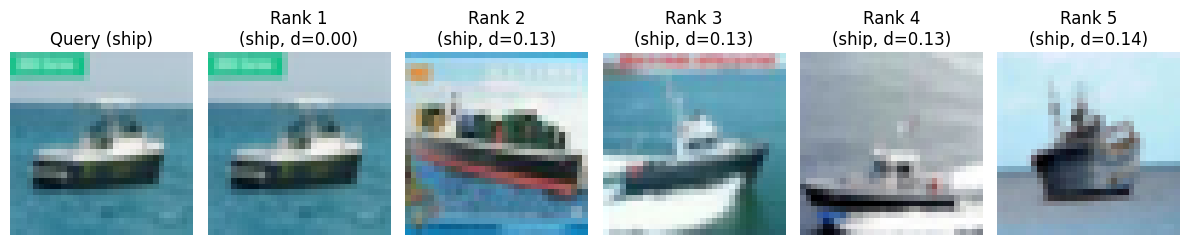

In [13]:
import matplotlib.pyplot as plt

def visualize_results(idx: HNSW, query_id: int, search_results: List[Tuple[int, float]]):
    """Visualizes the query image and the search results."""

    query_image, query_label = idx.dataset[query_id]
    query_label_name = idx.dataset.classes[query_label]

    print("\n--- Visualizing Query and Results ---")

    # Display the query image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, len(search_results) + 1, 1)
    plt.imshow(query_image)
    plt.title(f"Query ({query_label_name})")
    plt.axis('off')

    # Display the result images
    for i, (node_id, distance) in enumerate(search_results):
        result_image, result_label = idx.dataset[node_id]
        result_label_name = idx.dataset.classes[result_label]
        plt.subplot(1, len(search_results) + 1, i + 2)
        plt.imshow(result_image)
        plt.title(f"Rank {i+1}\n({result_label_name}, d={distance:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def query_image_index_and_report(idx: HNSW, query_id: int, k: int = 5):
    """Performs a similarity search and reports the results."""

    if query_id not in idx.embeddings:
         raise ValueError(f"Query ID {query_id} not in indexed embeddings.")

    query_vec = idx.embeddings[query_id]
    query_image, query_label = idx.dataset[query_id]

    print(f"\n--- Querying with Image ID {query_id} (Label: {idx.dataset.classes[query_label]}) ---")

    # Perform the search
    results = idx.search(query_vec, k=k)

    print(f"Top {k} Nearest Neighbors (ID, Distance, Label):")
    # Retrieve details for the top K results
    for rank, (node_id, distance) in enumerate(results):
        _img, label = idx.dataset[node_id]
        label_name = idx.dataset.classes[label]

        # Highlight the query image if it appears in the results (usually rank 0)
        marker = "<- QUERY" if node_id == query_id else ""
        print(f"Rank {rank+1}: ID: {node_id}, Dist: {distance:.4f}, Label: {label_name} {marker}")

    return results


# --- Main Execution Block ---
if __name__ == '__main__':
    try:
        # Step 1: Build the index from a real dataset
        # Check if index already exists and load it to save time
        try:
            hnsw_index = HNSW.load(INDEX_DIR)
            # Attach dataset/embeddings if needed for visualization/querying
            cifar_data = datasets.CIFAR10(root='./data', train=True, download=True)
            hnsw_index.__setattr__('dataset', cifar_data)
            print(f"Loading index from {INDEX_DIR}. Regenerating embeddings for querying/visualization...")
            _initialize_model()
            embeddings: Dict[int, np.ndarray] = {}
            for i in tqdm(range(min(N_IMAGES_TO_INDEX, len(cifar_data)))):
                 img, _label = cifar_data[i]
                 vec = get_image_embedding_from_pil(img)
                 if vec is not None and vec.shape[0] == IMAGE_DIM:
                     embeddings[i] = vec
            hnsw_index.__setattr__('embeddings', embeddings)

        except FileNotFoundError:
            print(f"Index not found at {INDEX_DIR}. Building new index...")
            hnsw_index = build_image_index(N_IMAGES_TO_INDEX, INDEX_DIR)


        # Step 2: Choose a random image from the indexed set to be the query
        # Use a random ID for a non-trivial search
        random_query_id = np.random.randint(0, min(N_IMAGES_TO_INDEX, len(hnsw_index.vectors)))
        print(f"Using random query ID: {random_query_id}")


        # Step 3: Query the HNSW Index
        search_results = query_image_index_and_report(hnsw_index, query_id=random_query_id, k=5)

        # Step 4: Visualize the results
        visualize_results(hnsw_index, query_id=random_query_id, search_results=search_results)


    except Exception as e:
        print(f"\nAn error occurred. If running for the first time, ensure 'pip install torch torchvision pillow' is complete.")
        print(f"Error details: {e}")